# Classification with `QNNClassifier`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.feature_map import ChebRx
from squlearn.expectation_operator import SummedPaulis
from squlearn.qnn import QNNClassifier, LogLoss
from squlearn.optimizers import SLSQP

In [2]:
executor = Executor("statevector_simulator")

## Classifier Setup
Let's start by defining a PQC

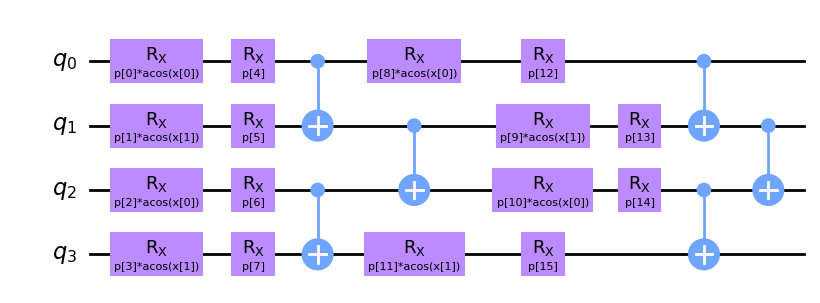

In [3]:
nqubits = 4

number_of_layers = 2
pqc = ChebRx(nqubits, 2, num_layers=number_of_layers)
pqc.draw("mpl")

Next, we also need a Expectation Operator

In [4]:
cost_op = SummedPaulis(nqubits)
print(cost_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


Now we're ready to define the `QNNClassifier` with randomly initialized parameters for the PQC and the Operator

In [5]:
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(cost_op.num_parameters)

clf = QNNClassifier(pqc, cost_op, executor, LogLoss(), SLSQP(), param_ini, param_op_ini)

## Generate Dataset

We use the `make_blobs` dataset from scikit-learn with 60 data points in two classes. We continue to scale the data and split it into a set for training and one for testing.

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = make_blobs(60, centers=2, random_state=0)
X = MinMaxScaler((-0.9, 0.9)).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Optimization

Now we're ready to fit the `QNNClassifier`.

In [7]:
clf.fit(X_train, y_train)

theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277 0.35833378 0.94909418]
Current value: 53.91731148368223
theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277 0.35833378 0.94909418]
Grad length: 78.8137946883677
grad [ 29.20968307  -7.00851243   3.87356112  26.09543311  14.37688475
 -12.56386137   4.25695183  16.90727269  16.409618     1.20997914
 -25.42009339  26.09543311   4.87180919   0.42888657 -12.26890644
  16.90727269 -31.25309488   5.27636422  23.13675446  -3.28330924
  18.32790444]
theta [-28.43198066   7.24605365  -3.04928259 -25.12968391 -13.40428363
  13.01731062  -3.64790937 -16.13174617 -15.76800466  -0.48796091
  25.45512992 -25.79698364  -4.

## Evaluation
Let's check the trained parameters.

In [8]:
print("Result Param:", clf._param)
print("Result ParamOp:", clf._param_op)

Result Param: [-1.08905353e+18  2.68959765e+18  9.32494560e+18  6.29767380e+18
  1.26654497e+19  1.61277308e+18  5.23595678e+18 -4.47851563e+17
 -2.32086982e+18  4.24241030e+18  1.14412292e+19  6.29767379e+18
  2.37434865e+18 -6.27449045e+18  6.47627310e+18 -4.47851573e+17]
Result ParamOp: [ 1.08246860e+19  2.45433168e+19 -2.94974575e+19  2.53533227e+19
 -3.54580036e+18]


Also, let's check the performance of the classifier on the test set using the mean accuracy.

In [9]:
clf.score(X_test, y_test)

0.5

Finally, let's visualize the classifiers performance. We plot the training and test set as well as the decision boundary of the `QNNClassifier`.

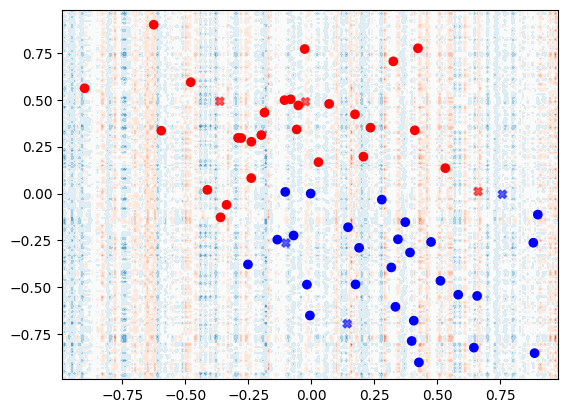

In [10]:
from matplotlib.colors import ListedColormap

xx, yy = np.meshgrid(np.arange(-0.99, 0.99, 0.01), np.arange(-0.99, 0.99, 0.01))

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.6)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, marker="X")